# Info 4700 Capstone: Machine Learning and Dataset Building

In [27]:
#Imports
import pandas as pd
import numpy as np
from skimage.io import imread
import skimage

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading CSV File from Labelling Spectrogram

This CSV file was created by a crowd-sourced labelling process in the Capstone class. Each file has the Google Drive link, the label given to the picture, and the new 'correct' label.

In [2]:
drive_and_label = pd.read_excel('Specogram Processing\Spectogram_Data_v1.xlsx')
drive_and_label.head()

,Spectogram,Meta_Label,New_Label
0,https://drive.google.com/uc?export=download&id...,320kpbs,192 kbps (LAME)
1,https://drive.google.com/uc?export=download&id...,320 kbps,320 kbps (LAME)
2,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (CBR)
3,https://drive.google.com/uc?export=download&id...,128 kbps,128 kpbs (AAC)
4,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (LAME)


## Calculating 'score' by picture
Here we are giving an overall score to each picture. We are trying to get an overall sense of how many black pixels there are by locating the shelf of the spectrogram.

Below is an example of what we're trying to use machine learning to label.

C:\Program Files\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


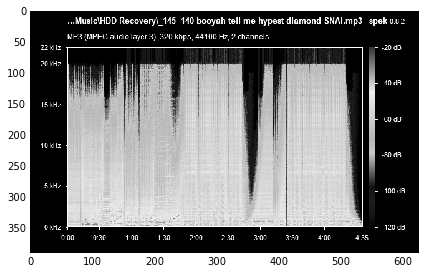

In [3]:
im = imread(drive_and_label.iloc[0]['Spectogram'], as_grey = True)
skimage.io.imshow(im)

## Creating Features from the Google Drive links.

Here we crop the picture and then give each column a 'score' as to how good the column is. We start at position 0 on the X and Y axis. From there, we look at the first column of pixels and loop downward to the bottom of the picture.

The if the shelf of the spectrogram is higher, there are going to be more non-black pixels in that column. So, in each column, if the pixel value is 0.0 (black) we reduce the score of that column by 1. If any pixel in the column does not equal 0.0 we give the score plus one. 

So, a column with a higher score in genral should give a higher quality.

**Note this loop takes a while to run since it has to access the GD links and create 624 features per image.**

In [92]:
#https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image/39382475
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2) 
    return img[starty:starty+cropy,startx:startx+cropx]

d = {}

for idx, row in drive_and_label.iterrows():
    #Find picture from GD link
    im = imread(row['Spectogram'], as_grey = True)

    #Crop Picture to get rid of top section
    #58 pixels is the standard header
    im = im[58:]

    #Find Bounds of image (to give baseline)
    y_bound, x_bound = im.shape

    #Looping across the x-axis (predefined resolution)
    final_score = []
    for ii in range(0, x_bound-1):
        #Reset Score per-coluimn
        score = 0
        for jj in range(0, y_bound-1): #Loop down each "x column"
            try:
                if im[ii, jj] == 0:
                    score -= 1
                elif im[ii,jj] != 0:
                    score += 1
            except:
                'IndexError'

        final_score.append(score)
    d[idx] = final_score 

In [10]:
df = pd.DataFrame.from_dict(d)
df = df.T
df.insert(0, 'label', drive_and_label['New_Label'])
df.tail()

df.to_csv('Spectogram Processing\SCORE_v1.csv', sep = ',')

NameError: name 'd' is not defined

In [4]:
df = pd.read_csv('Python_ML\SCORE_v1.csv')
df.tail()

,label,0,1,2,3,4,5,6,7,8,...,613,614,615,616,617,618,619,620,621,622
968,192 kbps (CBR),-287,-289,253,-171,-185,-163,-217,-225,-221,...,0,0,0,0,0,0,0,0,0,0
969,128 kbps (CBR),-287,-289,253,-49,-49,-29,-81,-85,-83,...,0,0,0,0,0,0,0,0,0,0
970,320 kbps (LAME),-287,-289,253,-189,-207,-181,-239,-243,-237,...,0,0,0,0,0,0,0,0,0,0
971,256 kbps (AAC),-287,-289,253,-89,-109,-83,-145,-143,-141,...,0,0,0,0,0,0,0,0,0,0
972,128 kbps (CBR),-287,-289,253,-247,-251,-233,-291,-291,-293,...,0,0,0,0,0,0,0,0,0,0


## Taking a look at the data

Here we can look at the number of labels in our data.

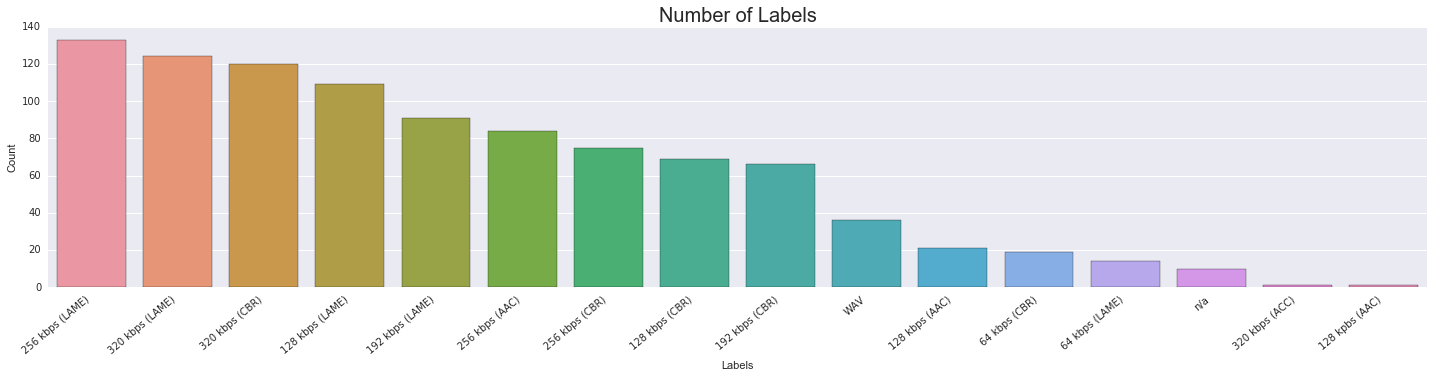

In [39]:
plt.figure(figsize=(20,5))
label_count = df['label'].value_counts()

ax = sns.barplot(label_count.index, label_count.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Number of Labels', size = 20)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## A Little More Feature Engineering

Now that we have all of these scores, we can add a few features at the end that are simple averages, sums, and other slight slimple mathematical operators to help see if any of these improve the accuracy.

In [ ]:
backup = df.copy() #Incase we mess stuff up

In [48]:
df['average'] = df.mean(numeric_only = True, axis = 1)
df['sum'] = df.sum(numeric_only= True, axis = 1)

## Transforming Data for Machine Learning 

Here we are creating the training and testing datasets, as well as, using Z-Score normalization to standardize the data.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scalar = StandardScaler()

In [50]:
#Using train test split to randomly assign data to training or testing
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], 
                                    df.iloc[:,0], test_size = 0.2)

#Standardizing X values with Z-score-standardization
scalar.fit(X_train)
X_train = scalar.transform(X_train)

scalar.fit(X_test)
X_test = scalar.transform(X_test)

This is a dummy classifier which uses a very simple algorithm to give us a baseline to improve off of.

In [53]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

classifier = DummyClassifier(strategy='most_frequent')

classifier.fit(X_train, y_train)

print("Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))

Training accuracy: 0.133676
Testing accuracy: 0.133676


## K-Fold Cross Validation

K-fold cross validation chunks our data into bins and allows for a consice way to test different algoriothms so we know which ones to improve.

In [75]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

Naive Bayes: 0.087363 (0.022044)
LR: 0.300683 (0.048945)
KNN: 0.267249 (0.047419)
TREE: 0.237796 (0.063407)
SVM: 0.320063 (0.057859)
MLP: 0.260839 (0.035335)
SGD: 0.210889 (0.044762)


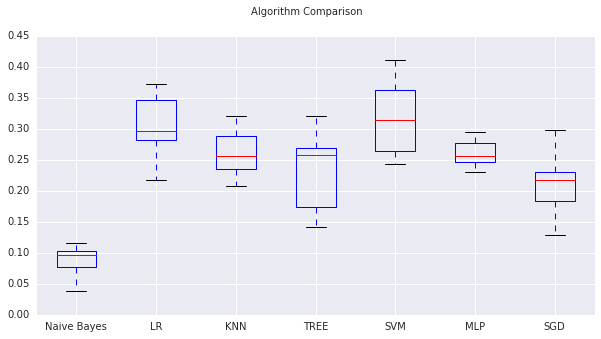

In [84]:
# prepare configuration for cross validation test harness
seed = 123
# prepare models
models = []

models.append(('Naive Bayes', GaussianNB()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(300,100))))
models.append(('SGD', SGDClassifier(loss = 'perceptron', 
                 tol=1.0e-12, random_state=123)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize = (10,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Which algorithms to tune?

I will now attempt to increase the testing accuracy of the three highest scoring algorithms (SVM, Logistic Regression, and MLP).

## Tuning the SVM Model

In [56]:
from sklearn.svm import SVC
train_max = []
test_max = []
switch = False
for kernel in ['linear', 'poly', 'poly', 'rbf']:
    print('--- Using a {} kernel ---'.format(kernel))
    for c_iter in [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]:
        #Init Classifier given kernel
        if kernel == 'poly' and switch == False:
            classifier = SVC(kernel=kernel, degree = 2, C=c_iter, random_state=123)
            if c_iter == 1000.0:
                switch = True #done with first poly move to second
        elif kernel == 'poly' and switch == True:
            classifier = SVC(kernel=kernel, degree = 3, C=c_iter, random_state=123)
        else:
            classifier = SVC(kernel=kernel, C=c_iter, random_state=123)
        
        #Fit classifier
        classifier.fit(X_train, y_train)
        
        #Find Accuracy
        print('C = {}'.format(c_iter))
        
        print("Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
        print("Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
        train_max.append(accuracy_score(y_train, classifier.predict(X_train)))
        test_max.append(accuracy_score(y_test, classifier.predict(X_test))) 
        
print(np.amax(train_max))
print(np.amax(test_max))

--- Using a linear kernel ---
C = 0.0001
Training accuracy: 0.294344
Test accuracy: 0.266667
C = 0.001
Training accuracy: 0.316195
Test accuracy: 0.276923
C = 0.01
Training accuracy: 0.340617
Test accuracy: 0.282051
C = 0.1
Training accuracy: 0.404884
Test accuracy: 0.302564
C = 1.0
Training accuracy: 0.562982
Test accuracy: 0.276923
C = 10.0
Training accuracy: 0.816195
Test accuracy: 0.271795
C = 100.0
Training accuracy: 0.966581
Test accuracy: 0.261538
C = 1000.0
Training accuracy: 0.997429
Test accuracy: 0.235897
--- Using a poly kernel ---
C = 0.0001
Training accuracy: 0.133676
Test accuracy: 0.148718
C = 0.001
Training accuracy: 0.142674
Test accuracy: 0.158974
C = 0.01
Training accuracy: 0.143959
Test accuracy: 0.158974
C = 0.1
Training accuracy: 0.160668
Test accuracy: 0.174359
C = 1.0
Training accuracy: 0.278920
Test accuracy: 0.251282
C = 10.0
Training accuracy: 0.363753
Test accuracy: 0.261538
C = 100.0
Training accuracy: 0.428021
Test accuracy: 0.235897
C = 1000.0
Training a

It seems that we are definitely overfitting the SVM model, but not achieiving a higher testing accuracy.

In [60]:
#Linear Kernal
lin_accuracy = []
rbf_accuracy = []
for N_iter in [20,50,100,200,400,800,970]:
    #print('Calling and fitting linear SVM with {} data points.'.format(N_iter))
    linear = SVC(kernel = 'linear', C = 101)
    linear.fit(X_train[:N_iter], y_train[:N_iter])
    #print('Finding accuracy...')
    lin_accuracy.append(accuracy_score(y_test, linear.predict(X_test)))
    #print('...done.')

#RBF Kernal
for N_iter in [20,50,100,200,400,800,970]:
    print('Calling and fitting RBF SVM with {} data points.'.format(N_iter))
    linear = SVC(kernel = 'poly', degree = 2, C = 1000)
    linear.fit(X_train[:N_iter], y_train[:N_iter])
    #print('Finding accuracy...')
    rbf_accuracy.append(accuracy_score(y_test, linear.predict(X_test)))
    #print('...done.')

Calling and fitting RBF SVM with 20 data points.
Calling and fitting RBF SVM with 50 data points.
Calling and fitting RBF SVM with 100 data points.
Calling and fitting RBF SVM with 200 data points.
Calling and fitting RBF SVM with 400 data points.
Calling and fitting RBF SVM with 800 data points.
Calling and fitting RBF SVM with 970 data points.


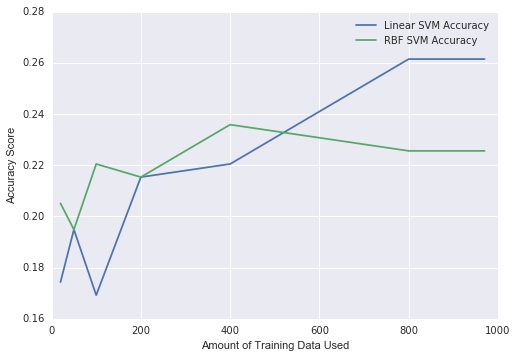

In [61]:
#Plotting
fig, ax = plt.subplots()

ax.plot([20,50,100,200,400,800,970], lin_accuracy, label = 'Linear SVM Accuracy')
ax.plot([20,50,100,200,400,800,970], rbf_accuracy, label = 'RBF SVM Accuracy')
ax.legend()
ax.set_xlabel('Amount of Training Data Used')
ax.set_ylabel('Accuracy Score')

Although we don't have much data it's obvious that more data for a linear SVM is better, although I'm not sure as to why an RBF kernel gets lower accuracy. It may be because the data is more linearally seperable than 'blobby' seperable for lack of better words.

## Tuning the MLP model

In [72]:
from sklearn.neural_network import MLPClassifier
for HL_1 in [50,100,200,300]:
    multi = MLPClassifier(hidden_layer_sizes=(HL_1), random_state=123)
    multi.fit(X_train, y_train)
    print("Test accuracy: %0.6f" % accuracy_score(y_test, multi.predict(X_test)))

C:\Users\spitf_000\AppData\Roaming\Python\Python35\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test accuracy: 0.256410
Test accuracy: 0.251282
Test accuracy: 0.292308
Test accuracy: 0.261538


In [73]:
for HL_1 in [200]:
    for HL_2 in [20,50,100,200]:
        print('{} units in first layer, {} units in second layer'.format(HL_1, HL_2))
        multi = MLPClassifier(hidden_layer_sizes=(HL_1, HL_2), random_state=123)
        multi.fit(X_train, y_train[:5000])
        print("Test accuracy: %0.6f" % accuracy_score(y_test, multi.predict(X_test)))

200 units in first layer, 20 units in second layer
Test accuracy: 0.230769
200 units in first layer, 50 units in second layer
Test accuracy: 0.256410
200 units in first layer, 100 units in second layer
Test accuracy: 0.241026
200 units in first layer, 200 units in second layer
Test accuracy: 0.266667


Even with messing with the layers we still don't achieve a higher accuracy than 32%

## Tuning a Logistic Regression Model

Here we are tuning different levels of the hyperparameter aplpha to see if we can achieve a higher testing score.

C:\Users\spitf_000\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


-- The training accuracy scores as alpha increases are --
[0.2365038560411311, 0.2892030848329049, 0.31362467866323906, 0.3380462724935733, 0.2994858611825193, 0.2365038560411311, 0.08097686375321336]
-- The testing accuracy scores as alpha increases are --
[0.18974358974358974, 0.24615384615384617, 0.21025641025641026, 0.2564102564102564, 0.2564102564102564, 0.17435897435897435, 0.06153846153846154]


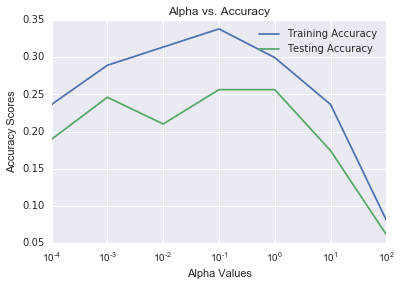

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

scores = []
alp_iter = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
for alp in alp_iter:
    lr = SGDClassifier(alpha = alp, average = False, loss = 'log', max_iter = 1000, tol = 1.0e-12, random_state = 123)
    lr.fit(X_train, y_train)
    val = ((accuracy_score(y_train, lr.predict(X_train))),accuracy_score(y_test, lr.predict(X_test)))
    scores.append(val)
    
acc_train, acc_test = zip(*scores)
print('-- The training accuracy scores as alpha increases are --')
print(list(acc_train))
print('-- The testing accuracy scores as alpha increases are --')
print(list(acc_test))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_xlabel('Alpha Values')
ax.set_ylabel('Accuracy Scores')
ax.set_title('Alpha vs. Accuracy')

ax.plot(alp_iter, acc_train, label = 'Training Accuracy')
ax.plot(alp_iter, acc_test, label = 'Testing Accuracy')
ax.legend()

plt.show()

Overall, the hyperparameters do not improve the accuracy in the logistic regression model.

## Conclusions

It seems after all of the hyperparameter tuning there is not viable way to increase the testing accuracy past roughly 30%. This means in general, all models are *overfitting* the data. 

Ways to improve accuracy:
- improve feature engineering
- accumulate more data